# E7 - Transportation simplex algorithm -Nicolas DESJONQUERES

## I. Importing a transportation problem from a .csv file

In [268]:
import csv
import numpy as np

In [269]:
def get_TP_from_csv(file_path):
    with open(file_path, 'r') as file:
        reader = csv.reader(file, delimiter = ';', quoting = csv.QUOTE_NONNUMERIC)
        
        
        row_num = 0
        costs = []
        
        for row in reader:
            if row_num == 0:
                supply = np.array(row)
            elif row_num == 1:
                demand = np.array(row)
            else:
                costs.append(row)
            
            row_num += 1
    
    return supply, demand, np.array(costs)

## II. Solving the transportation problem

In [270]:
import numpy as np

In [271]:
def nw_corner_rule(supply, demand): 
    # we initialize the solution as an empty 2d array
    solution = np.zeros((len(supply), len(demand)))
    
    x, y = 0, 0
    
    # we go on until we reach the bottom left of the solution
    while solution.shape != (y, x):
        # we take the maximum we can put on the cell which the minimum value...
        # ... between supply and demand
        solution[y, x] = min(supply[y], demand[x])
        
        # we update the demand and supply
        demand[x], supply[y] = max(demand[x] - supply[y], 0), supply[y] - min(supply[y], demand[x])
        
        # if the demand of the column is answered, go to the next column
        if demand[x] == 0: x += 1
            
        # if there is no more supply on a row, go to the next one
        if supply[y] == 0: y += 1
        
    return solution

In [272]:
def get_w(solution, costs):
    # we get the number of columns and rows of the 2d array
    nrows, ncols = solution.shape
    
    # we initalize u and v
    u = np.array([np.nan]*nrows)
    u[0] = 0
    
    v = np.array([np.nan]*ncols)

    # we get the list of indices where solution is non-zero
    _x, _y = np.where(solution > 0)
    nonzero = list(zip(_x, _y))

    # we continue until u and v are full
    while any(np.isnan(u)) or any(np.isnan(v)):
        # we iterate through non zero indices
        for i, j in nonzero:
            # we do the algorithm to find each value of u and v
            if np.isnan(u[i]) and not np.isnan(v[j]):
                u[i] = costs[i, j] - v[j]
                
            elif not np.isnan(u[i]) and np.isnan(v[j]):
                v[j] = costs[i, j] - u[i]
                
            else:
                continue

    # we initialize w
    w = np.zeros(costs.shape)

    # we iterate through the costs matrix to put -inf for each value if it...
    # ... is not zero in solution to signify that we cannot have a cell...
    # ... enter if it is already present in the solution
    for y in range(costs.shape[0]):
        for x in range(costs.shape[1]):
            if solution[y, x] != 0:
                w[y, x] = -np.inf
            else:
                w[y, x] = u[y] + v[x] - costs[y, x]
    
    n, m = w.shape
    
    i_max = (0, 0)
    
    # we check if we have a greater value that has a cycle possible for...
    # ... each value of w
    for i in range(n):
        for j in range(m):
            if w[i, j] > w[i_max] and get_cycle(solution, (i, j)) != []:
                i_max = (i, j)
    
    return w, i_max

In [273]:
def get_cycle(solution, start_index):
    n, m = solution.shape
    
    paths = []
    
    # checks if the index is valid
    def is_valid_index(i, j):
        return 0 <= i < n and 0 <= j < m
    
    # we search all 4 different 4-cell paths starting from (i, j), which is...
    # ... a brute force method, but i did not have the mental strength to...
    # ... improve it
    def search(i, j, path, solution):
        if len(path) == 4:
            paths.append(path.copy())
            return
        
        for x, y in [(r, c) for r in range(solution.shape[0]) for c in range(solution.shape[1])]:
            if is_valid_index(x, y) and (x, y) not in path:
                search(x, y, path + [(x, y)], solution)
    
    i, j = start_index
    search(i, j, [(i, j)], solution)
    
    # we filter the paths to find the cycle
    
    # values of the path must be all > 0 except the start
    paths = [p for p in paths if all(solution[n] > 0 for n in p[1:])]
    
    # the path must be square
    paths = [p for p in paths if len(set(y for y, _ in p)) == 2 and len(set(x for _, x in p)) == 2]
    
    # we must not have diagonal moves in the path
    paths = [p for p in paths if not any([p[i-1][0] != p[i][0] and p[i-1][1] != p[i][1] for i in range(len(p))])]
    
    # if no path exist, the cell is not valid, so return an empty list to...
    # ... avoid an error
    if paths == []:
        return []
    
    # return the first path of the list, which is random, but every path has...
    # ... the same outcome, so it does not matter
    return paths[0]

In [274]:
def get_total_cost(solution, costs):
    total_cost = 0
    
    n, m = solution.shape
    
    # we calculate the cost of the solution
    for i in range(n):
        for j in range(m):
            total_cost += solution[i, j] * costs[i, j]
    
    return total_cost

In [275]:
def transportation(supply, demand, costs):
    # we only solve balanced problems
    assert sum(supply) == sum(demand)

    # we get the initial feasible solution
    solution = nw_corner_rule(supply, demand)
    costs_evolution = np.array([get_total_cost(solution, costs)])
    
    # a set maximum number of iterations as a safety if the loop doesnt...
    # ... terminate correctly
    max_iter = 25
    
    while True:
        # we get w and the index of the cell that enters the solution
        w, i_max = get_w(solution, costs)
        
        # we break out of the loop if no improvement can be made
        if all([cell <= 0 for row in w for cell in row]):
            break
        
        # we get the cycle 
        cycle = get_cycle(solution, i_max)
        
        # we get the minimum value between the two cells that are next to...
        # ... the entering cell
        tetha = min(solution[cycle[-1]], solution[cycle[1]])
        
        # we update the solution with the cycle
        for i in range(len(cycle)):
            if i % 2 == 0:
                solution[cycle[i]] += tetha
            else:
                solution[cycle[i]] -= tetha
                
        # we update the evolution of the total cost of the solution
        costs_evolution = np.append(costs_evolution, get_total_cost(solution, costs))
        
        # safety break out of the loop
        if max_iter < 0:
            break
        else:
            max_iter -= 1
    
    return solution, get_total_cost(solution, costs), costs_evolution

## III. Visualisation of the problem

In [276]:
import pandas as pd
import matplotlib.pyplot as plt

In [277]:
def display_transportation_problem(supply, demand, costs):
    data = {str(demand[i]): [costs[j, i] for j in range(len(supply))] for i in range(len(demand))}
    index = [str(n) for n in supply]

    df = pd.DataFrame(data, index=index)

    fig, ax = plt.subplots(figsize=(8, 4))  # Adjust the figure size as needed
    ax.axis('off')
    table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center', cellLoc='center')

    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)

    plt.title("Transportation Problem", fontsize=16)
    plt.ylabel("Demand")

    ax.annotate('Supply', xy=(-0.1, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                fontsize=12, ha='right', va='center', rotation=90)

    ax.annotate('Demand', xy=(0.5, -0.15), xytext=(0, ax.xaxis.labelpad + 95 + 18 * (len(costs) + 1)),
                xycoords=ax.xaxis.label, textcoords='offset points',
                fontsize=12, ha='center', va='top')
    plt.show()

In [278]:
def plot_cost_evolution(costs_evolution):
    iterations = np.arange(1, len(costs_evolution) + 1)
    
    plt.figure(figsize=(8, 6))
    plt.plot(iterations, costs_evolution, marker='+', linestyle='-')
    plt.title('Evolution of the cost of the solution')
    plt.xlabel('Iteration')
    plt.ylabel('Total Cost')
    plt.show()

In [279]:
def display_transportation_solution(allocation_matrix):
    df = pd.DataFrame(allocation_matrix)

    plt.figure(figsize=(8, 6))
    plt.imshow(allocation_matrix, cmap='RdYlGn', interpolation='nearest')

    for i in range(allocation_matrix.shape[0]):
        for j in range(allocation_matrix.shape[1]):
            plt.text(j, i, allocation_matrix[i, j], ha='center', va='center', color='black', fontsize=12)

    plt.title('Solution')
    plt.xlabel('Destinations')
    plt.ylabel('Sources')
    
    plt.xticks(np.arange(0, df.shape[1]), labels=np.arange(1, df.shape[1] + 1))
    plt.yticks(np.arange(0, df.shape[0]), labels=np.arange(1, df.shape[0] + 1))

    # Show the plot
    plt.show()

In [280]:
def visualise_transportation_problem(supply, demand, costs):
    display_transportation_problem(supply, demand, costs)

    solution, total_cost, costs_evolution = transportation(supply, demand, costs)

    plot_cost_evolution(costs_evolution)

    display_transportation_solution(solution)

    print("Optimal solution cost : ", total_cost)

## IV. Some examples

### a) Example from the video

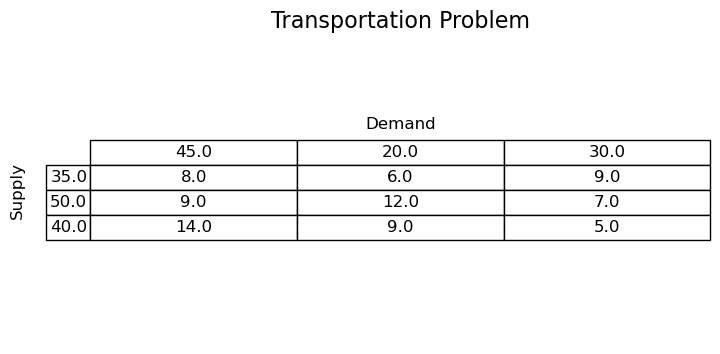

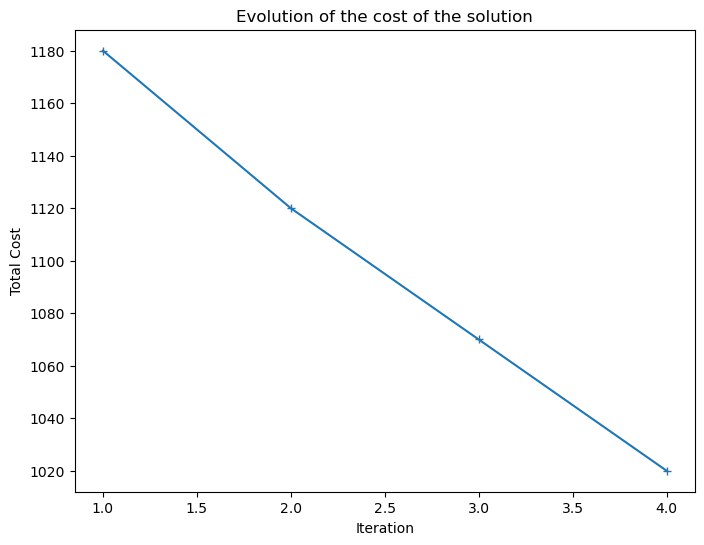

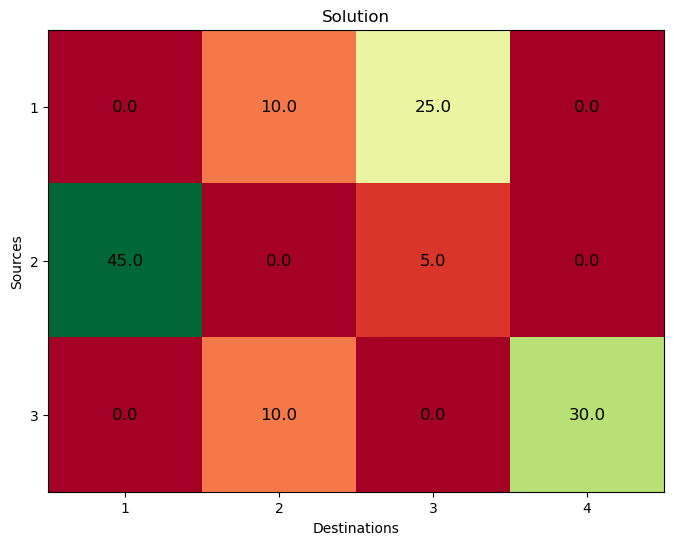

Optimal solution cost :  1020.0


In [281]:
supply, demand, costs = get_TP_from_csv("example_from_video.csv")
visualise_transportation_problem(supply, demand, costs)

### b) Exercise 2 from course

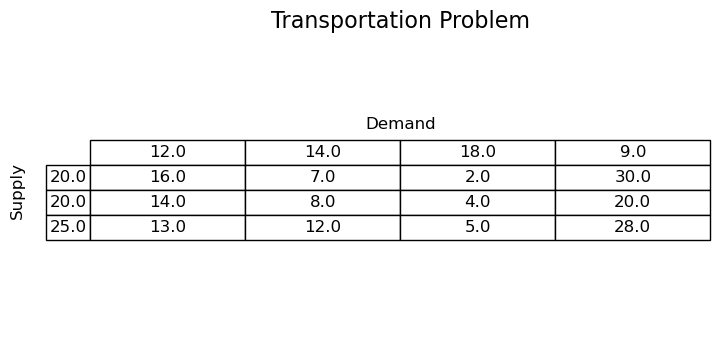

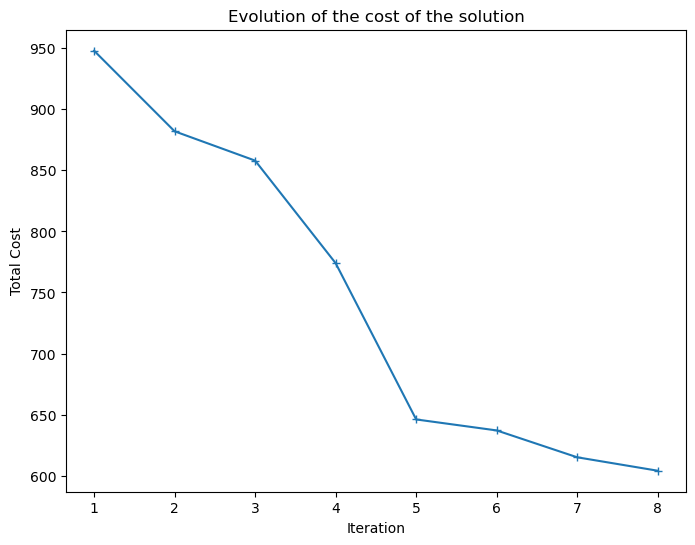

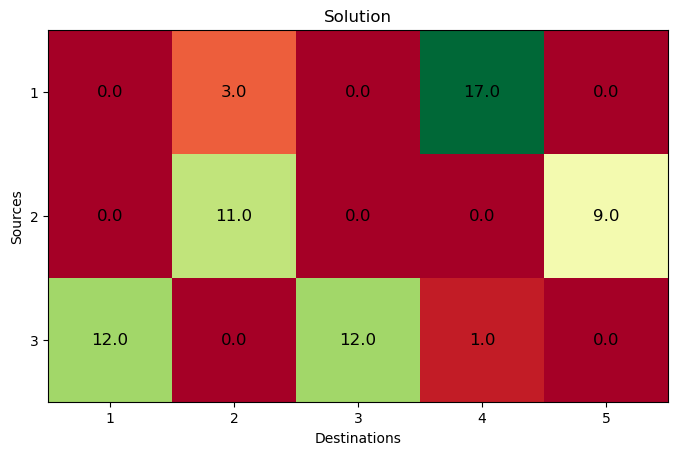

Optimal solution cost :  604.0


In [282]:
supply, demand, costs = get_TP_from_csv("exercise_2.csv")
visualise_transportation_problem(supply, demand, costs)